### Dividend Capture Strategy Agent using DQN

In this project, i will create the environment and an RL agent that learns to choose the best scheme of dividend investing given a dividend calendar and up-to-date market data.

Importing libraries

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re #, xlrd
import datetime, pickle, math#, openpyxl
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import precision_score, recall_score, make_scorer
import collections
from collections import deque

import random, time

import tensorflow as tf
#import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
#from keras.models import model_from_json

import warnings
warnings.filterwarnings("ignore")

In [6]:
#from env_dqn import market
from env_dqn import market

In [116]:
#Track total reward per episode and check for stability which indicated convergence
all_episode_portfolio=[] #saving the portfolio value at end of each episode
all_episode_rewards=[] #reward at end of each episode
all_actions=[]
all_episode_dividends=[]
#random_action_count=0 #count steps with random action selection
#total_steps_count=0 #count steps in all episodes

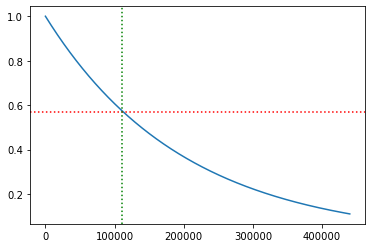

In [283]:
episodes_counts = np.arange(0,400*1100)
epsilon = []
for i in range(0,400*1100):
    epsilon.append(0 + (1 - 0) * np.exp(-0.000005*i))

plt.plot(episodes_counts, epsilon)
plt.axhline(y=0.57, color='r', linestyle=':')
plt.axvline(x=100*1100, color='g', linestyle=':')
plt.show()

In [118]:
#action is returned as the index of the chosen action from action space; it is needed to be saved as an index for agent to work
#only needs encoded state to work; can call env.function() to do it within this block
#similarly, env.function() can be called to convert the action number to a ticker
class REINFORCEAgent:
    def __init__(self, state_length, state_width,action_size):
        
        # get size of state and action
        self.state_length = state_length #state_size
        self.state_width = state_width
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.01 #0.99
        self.learning_rate = 0.01 #0.001
        self.hidden1, self.hidden2, self.hidden3  = 128, 64, 32

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []
        self.full_state=[]
        
        self.batch_size = 32
        
        #Set epsilon for decay
        self.epsilon_max = 1
        self.epsilon_decay = np.exp(-0.000005)#(-0.0028)#(-0.000005) #-0.00035, -0.000003
        self.epsilon_min = 0.00000001      
        self.epsilon=self.epsilon_max
        self.total_steps_count=0
        self.random_action_count=0
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
    
    def custom_loss(self, y_true, y_pred):
        loss_calc=0.0
        for i in range(len(y_pred)):
            if (y_pred[i][0][1]>0.5) & (y_true[i][0][1]==1):
                loss_calc=-0.005
            elif (y_pred[i][0][1]>0.5) & (y_true[i][0][1]==0):
                loss_calc=0.03
        return loss_calc
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden1, input_shape=(self.state_length,self.state_width), activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Flatten()) 
        model.add(Dropout(0.5))
        model.add(Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dropout(0.6))
        model.add(Dense(self.hidden3, activation='relu', kernel_initializer='glorot_uniform'))
        #model.add(Dropout(0.7))
         
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        #model.summary()
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
    
    # returns index of chosen action in env.action_space
    def get_action(self, state, reshaped_encoded_state):
        valid_actions=env.get_valid_actions(state)
        valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
        z=np.random.rand()
        if z <= self.epsilon:                         #if z<=epsilon, then go exploration; select random action from all possible actions
            return valid_actions_idx[random.randrange(len(valid_actions_idx))]
        else:                                         #if z>epsilon, then go exploitation; select best action from all possible actions
            #Encode state first and then send to model for prediction; the agent appears to only need the encoded state to work
            #Action has to be in the form of a number for this function to work
            q_value = self.model.predict(reshaped_encoded_state)
            valid_q_vals=[q_value[0][i] for i in valid_actions_idx]
            return valid_actions_idx[np.argmax(valid_q_vals)]

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward, next_state):
        # save sample <s,a,r,s'> to the replay memory
        # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state)) #, #done))
        
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # update network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_length,self.state_width)) #,1)) # write here s'
            update_input = np.zeros((self.batch_size,self.state_length,self.state_width)) #,1)) # write here s
            actions, rewards = [], []
            
            for i in range(self.batch_size): #populate arrays & lists of s,a,r,s' based on mini_batch picked up from memory
                state1, action1, reward1, next_state1 = mini_batch[i]
                state_encod1 = env.state_encoder(state1).reshape(-1,329,57) #,action)
                next_state_encod= env.state_encoder(next_state1).reshape(-1,329,57)
                update_input[i] = state_encod1       #s
                actions.append(action1)              #a
                rewards.append(reward1)              #r
                update_output[i] = next_state_encod #s'
                
            # 1. Predict the target from earlier model
            Q_s_a = self.model.predict(update_input)
                            
            # 2. Get the target for the Q-network
            Q_s_prime_a=self.model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                if terminal_state==True:
                    Q_s_a[i][actions[i]] = rewards[i]
                else:
                    Q_s_a[i][actions[i]] = rewards[i] + self.discount_factor*(np.amax(Q_s_prime_a[i])) # Q Learning: get maximum Q value at s' from target model
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, Q_s_a, batch_size=self.batch_size, epochs=3, verbose=0)
        else:
            return

    def save(self, name):
        self.model.save_weights(name)

In [9]:
training_cols2=['Due_Dividend', 'p_Open', 'p_High', 'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc', 'Weekday', 'Month',
 'Week', 'p_Open/p_Close', 'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close', 'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5',
 'ATTO_45', 'Beta_22', 'Beta_64', 'MACD_short', 'MACD_Signal_short', 'MACD_hist_short', 'MACD_long', 'MACD_Signal_long',  'MACD_hist_long', 'PPO_short', 'PPO_long', 'Momentum_long', 'Momentum_short', 'StochFast_K', 'StochFast_D', 'StochSlow_K',  'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI', 'Bias', '10_day_SMA/p_Close', '12_day_EMA/p_Close', '10_day_WMA/p_Close',
 '10_day_SMA', '12_day_EMA', '10_day_WMA', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Rel_ExDD_-3', 'Rel_ExDD_-2',  'Rel_ExDD_-1', 'Rel_ExDD_Invalid']

In [7]:
#Initialize environment
env=market()
# Defining number of episodes to train
EPISODES = 450 #400

In [10]:
#Initialize agent

# get size of state and action from environment
#state_size = len(env.action_space)-1,len(training_cols2) #(329,57)
state_length=len(env.action_space)-1 #329
state_width=len(training_cols2) #57
action_size = len(env.action_space) #329+1 including the action of not buying anything

triggers=[0,0,0,0,0,0,0]
all_triggers=[]

In [124]:
# make REINFORCE agent
agent = REINFORCEAgent(state_length, state_width, action_size)

In [125]:
agent.model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 329, 128)          7424      
_________________________________________________________________
flatten_6 (Flatten)          (None, 42112)             0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 42112)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2695232   
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 330)              

In [126]:
start_time = time.time()

for episode in tqdm_notebook(range(EPISODES)):
    # Write code here
    terminal_state=False
    #month_dividend=0
    episode_steps=0
    episode_reward=0
    episode_dividend=0
        
    #set to random state at start of episode, state is [dataframe,array]
    current_state = env.reset() #env.reset_random() 
    investment=current_state[1]
    portfolio=investment

    while not terminal_state:#done:
        # Reshaping in the form of (batch_size), state_size for input to neural network
        state_encod=env.state_encoder(current_state)
        #state = np.reshape(state, [1, state_size])
        
        # get action for the current state and go one step in environment
        action = agent.get_action(current_state,state_encod.reshape(-1,329,57)) 
        all_actions.append(env.action_space[action])
        
        next_state, reward, dividend, trig_count = env.action_success_fn(action,current_state)
        reward=float(reward)
        episode_reward+=reward
        episode_steps+=1
        episode_dividend+=dividend
        
        triggers[0]+=trig_count[0]
        triggers[1]+=trig_count[1]
        triggers[2]+=trig_count[2]
        triggers[3]+=trig_count[3]
        triggers[4]+=trig_count[4]
        triggers[5]+=trig_count[5]
        triggers[6]+=trig_count[6]

        # save the sample <s, a, r, s'> 
        agent.append_sample(current_state, action, reward, next_state)

        # Train the model by calling function agent.train_model after evey 5 sampling steps
        if (episode_steps+1)%5==0:
            agent.train_model()
            
        current_state = next_state
        
        if (env.get_date(current_state)>=pd.to_datetime(datetime.date(2019,1,1))) or (investment+episode_reward<=0.5*investment): #or (episode_steps>=23) : 
            #episodes are limited to 1 Jan 2019 only or 50% drop in portfolio value
            terminal_state=True
            
    if terminal_state:     
        portfolio+=episode_reward
        all_episode_rewards.append(episode_reward) #saving the reward at end of each episode
        all_episode_portfolio.append(portfolio)
        all_triggers.append(triggers)
        all_episode_dividends.append(episode_dividend)
    
    if (episode+1)%1==0:
        episode_count=episode+1
        elapsed_time = time.time() - start_time
        print('Episode:{},Epsilon:{},Steps:{},Reward:{},Portfolio:{},Dividend:{},Triggers:{}, Actions:{}'.
              format(episode_count,round(agent.epsilon,2),episode_steps,round(episode_reward,2),round(portfolio,2),round(episode_dividend,2),triggers, sum(triggers)))                
    triggers=[0,0,0,0,0,0,0]

Episode:1,Epsilon:0.99,Steps:1193,Reward:1.9,Portfolio:2.9,Dividend:2.35,Triggers:[446, 15, 184, 28, 209, 194, 0], Actions:1076
Episode:2,Epsilon:0.99,Steps:1193,Reward:1.15,Portfolio:2.15,Dividend:2.0,Triggers:[470, 38, 168, 14, 233, 162, 1], Actions:1086
Episode:3,Epsilon:0.98,Steps:1193,Reward:1.34,Portfolio:2.34,Dividend:2.22,Triggers:[474, 34, 186, 20, 212, 170, 1], Actions:1097
Episode:4,Epsilon:0.98,Steps:1193,Reward:1.55,Portfolio:2.55,Dividend:2.25,Triggers:[474, 24, 188, 18, 214, 168, 1], Actions:1087
Episode:5,Epsilon:0.97,Steps:1193,Reward:1.97,Portfolio:2.97,Dividend:2.24,Triggers:[454, 25, 192, 19, 209, 174, 0], Actions:1073
Episode:6,Epsilon:0.96,Steps:1193,Reward:1.53,Portfolio:2.53,Dividend:2.3,Triggers:[477, 23, 204, 28, 202, 150, 1], Actions:1085
Episode:7,Epsilon:0.96,Steps:1193,Reward:1.73,Portfolio:2.73,Dividend:2.09,Triggers:[466, 34, 181, 30, 208, 160, 0], Actions:1079
Episode:8,Epsilon:0.95,Steps:1193,Reward:2.18,Portfolio:3.18,Dividend:2.36,Triggers:[479, 25, 

Episode:64,Epsilon:0.68,Steps:1193,Reward:2.06,Portfolio:3.06,Dividend:2.86,Triggers:[488, 35, 214, 26, 207, 150, 1], Actions:1121
Episode:65,Epsilon:0.68,Steps:1193,Reward:3.06,Portfolio:4.06,Dividend:3.25,Triggers:[480, 19, 212, 21, 210, 179, 0], Actions:1121
Episode:66,Epsilon:0.67,Steps:1193,Reward:2.99,Portfolio:3.99,Dividend:3.17,Triggers:[505, 28, 215, 30, 192, 155, 0], Actions:1125
Episode:67,Epsilon:0.67,Steps:1193,Reward:1.89,Portfolio:2.89,Dividend:2.7,Triggers:[524, 31, 178, 20, 212, 157, 1], Actions:1123
Episode:68,Epsilon:0.67,Steps:1193,Reward:2.08,Portfolio:3.08,Dividend:2.91,Triggers:[507, 29, 187, 28, 231, 159, 1], Actions:1142
Episode:69,Epsilon:0.66,Steps:1193,Reward:2.96,Portfolio:3.96,Dividend:3.01,Triggers:[512, 25, 204, 16, 204, 165, 0], Actions:1126
Episode:70,Epsilon:0.66,Steps:1193,Reward:2.79,Portfolio:3.79,Dividend:3.1,Triggers:[480, 33, 196, 25, 230, 161, 0], Actions:1125
Episode:71,Epsilon:0.65,Steps:1193,Reward:2.8,Portfolio:3.8,Dividend:3.11,Triggers:[4

Episode:127,Epsilon:0.47,Steps:1193,Reward:3.47,Portfolio:4.47,Dividend:3.61,Triggers:[501, 21, 211, 19, 197, 189, 0], Actions:1138
Episode:128,Epsilon:0.47,Steps:1193,Reward:3.45,Portfolio:4.45,Dividend:3.53,Triggers:[479, 26, 236, 18, 203, 178, 0], Actions:1140
Episode:129,Epsilon:0.46,Steps:1193,Reward:3.5,Portfolio:4.5,Dividend:3.69,Triggers:[512, 24, 207, 23, 204, 166, 0], Actions:1136
Episode:130,Epsilon:0.46,Steps:1193,Reward:3.42,Portfolio:4.42,Dividend:3.53,Triggers:[500, 29, 209, 19, 203, 164, 0], Actions:1124
Episode:131,Epsilon:0.46,Steps:1193,Reward:3.68,Portfolio:4.68,Dividend:3.78,Triggers:[508, 22, 215, 21, 204, 168, 0], Actions:1138
Episode:132,Epsilon:0.46,Steps:1193,Reward:3.71,Portfolio:4.71,Dividend:3.73,Triggers:[521, 21, 196, 16, 215, 179, 0], Actions:1148
Episode:133,Epsilon:0.45,Steps:1193,Reward:3.36,Portfolio:4.36,Dividend:3.51,Triggers:[502, 19, 208, 17, 213, 186, 0], Actions:1145
Episode:134,Epsilon:0.45,Steps:1193,Reward:3.29,Portfolio:4.29,Dividend:3.32,T

Episode:190,Epsilon:0.32,Steps:1193,Reward:3.7,Portfolio:4.7,Dividend:3.82,Triggers:[515, 31, 212, 16, 216, 168, 0], Actions:1158
Episode:191,Epsilon:0.32,Steps:1193,Reward:3.26,Portfolio:4.26,Dividend:3.91,Triggers:[506, 27, 212, 18, 213, 178, 1], Actions:1155
Episode:192,Epsilon:0.32,Steps:1193,Reward:3.75,Portfolio:4.75,Dividend:3.8,Triggers:[497, 29, 228, 17, 207, 184, 0], Actions:1162
Episode:193,Epsilon:0.32,Steps:1193,Reward:4.13,Portfolio:5.13,Dividend:4.25,Triggers:[500, 26, 242, 22, 201, 170, 0], Actions:1161
Episode:194,Epsilon:0.31,Steps:1193,Reward:3.73,Portfolio:4.73,Dividend:3.94,Triggers:[504, 28, 210, 20, 210, 183, 0], Actions:1155
Episode:195,Epsilon:0.31,Steps:1193,Reward:4.07,Portfolio:5.07,Dividend:4.15,Triggers:[504, 32, 224, 19, 203, 174, 0], Actions:1156
Episode:196,Epsilon:0.31,Steps:1193,Reward:3.45,Portfolio:4.45,Dividend:3.72,Triggers:[502, 32, 224, 25, 203, 175, 0], Actions:1161
Episode:197,Epsilon:0.31,Steps:1193,Reward:3.68,Portfolio:4.68,Dividend:3.76,Tr

Episode:253,Epsilon:0.22,Steps:1193,Reward:4.15,Portfolio:5.15,Dividend:4.3,Triggers:[508, 32, 225, 18, 214, 176, 0], Actions:1173
Episode:254,Epsilon:0.22,Steps:1193,Reward:4.27,Portfolio:5.27,Dividend:4.26,Triggers:[514, 21, 231, 17, 215, 169, 0], Actions:1167
Episode:255,Epsilon:0.22,Steps:1193,Reward:4.46,Portfolio:5.46,Dividend:4.39,Triggers:[502, 18, 236, 19, 210, 175, 0], Actions:1160
Episode:256,Epsilon:0.22,Steps:1193,Reward:4.03,Portfolio:5.03,Dividend:4.14,Triggers:[525, 30, 218, 19, 201, 166, 0], Actions:1159
Episode:257,Epsilon:0.22,Steps:1193,Reward:4.03,Portfolio:5.03,Dividend:4.07,Triggers:[543, 24, 213, 21, 217, 153, 0], Actions:1171
Episode:258,Epsilon:0.21,Steps:1193,Reward:4.16,Portfolio:5.16,Dividend:4.17,Triggers:[523, 22, 222, 19, 212, 172, 0], Actions:1170
Episode:259,Epsilon:0.21,Steps:1193,Reward:4.11,Portfolio:5.11,Dividend:3.99,Triggers:[529, 17, 235, 21, 218, 149, 0], Actions:1169
Episode:260,Epsilon:0.21,Steps:1193,Reward:4.07,Portfolio:5.07,Dividend:4.17,

Episode:316,Epsilon:0.15,Steps:1193,Reward:4.15,Portfolio:5.15,Dividend:4.13,Triggers:[508, 23, 240, 19, 213, 174, 0], Actions:1177
Episode:317,Epsilon:0.15,Steps:1193,Reward:4.11,Portfolio:5.11,Dividend:4.09,Triggers:[516, 26, 227, 23, 227, 161, 0], Actions:1180
Episode:318,Epsilon:0.15,Steps:1193,Reward:4.19,Portfolio:5.19,Dividend:4.2,Triggers:[515, 24, 238, 19, 215, 173, 0], Actions:1184
Episode:319,Epsilon:0.15,Steps:1193,Reward:4.2,Portfolio:5.2,Dividend:4.21,Triggers:[510, 29, 227, 20, 220, 174, 0], Actions:1180
Episode:320,Epsilon:0.15,Steps:1193,Reward:3.99,Portfolio:4.99,Dividend:4.03,Triggers:[525, 26, 218, 15, 215, 180, 0], Actions:1179
Episode:321,Epsilon:0.15,Steps:1193,Reward:3.89,Portfolio:4.89,Dividend:4.0,Triggers:[527, 24, 225, 23, 211, 170, 0], Actions:1180
Episode:322,Epsilon:0.15,Steps:1193,Reward:4.06,Portfolio:5.06,Dividend:4.08,Triggers:[520, 29, 225, 17, 225, 168, 0], Actions:1184
Episode:323,Epsilon:0.15,Steps:1193,Reward:4.1,Portfolio:5.1,Dividend:4.09,Trigg

Episode:379,Epsilon:0.1,Steps:1193,Reward:4.12,Portfolio:5.12,Dividend:4.14,Triggers:[502, 29, 236, 22, 226, 166, 0], Actions:1181
Episode:380,Epsilon:0.1,Steps:1193,Reward:4.29,Portfolio:5.29,Dividend:4.22,Triggers:[491, 27, 238, 18, 238, 167, 0], Actions:1179
Episode:381,Epsilon:0.1,Steps:1193,Reward:4.34,Portfolio:5.34,Dividend:4.26,Triggers:[505, 27, 246, 17, 221, 169, 0], Actions:1185
Episode:382,Epsilon:0.1,Steps:1193,Reward:4.21,Portfolio:5.21,Dividend:4.26,Triggers:[503, 24, 241, 22, 222, 166, 0], Actions:1178
Episode:383,Epsilon:0.1,Steps:1193,Reward:4.22,Portfolio:5.22,Dividend:4.23,Triggers:[510, 23, 237, 23, 214, 169, 0], Actions:1176
Episode:384,Epsilon:0.1,Steps:1193,Reward:4.21,Portfolio:5.21,Dividend:4.23,Triggers:[496, 26, 244, 19, 224, 173, 0], Actions:1182
Episode:385,Epsilon:0.1,Steps:1193,Reward:4.16,Portfolio:5.16,Dividend:4.14,Triggers:[505, 28, 251, 20, 225, 156, 0], Actions:1185
Episode:386,Epsilon:0.1,Steps:1193,Reward:4.24,Portfolio:5.24,Dividend:4.33,Trigger

Episode:442,Epsilon:0.07,Steps:1193,Reward:4.23,Portfolio:5.23,Dividend:4.23,Triggers:[511, 27, 233, 20, 225, 168, 0], Actions:1184
Episode:443,Epsilon:0.07,Steps:1193,Reward:4.18,Portfolio:5.18,Dividend:4.19,Triggers:[496, 30, 237, 18, 229, 175, 0], Actions:1185
Episode:444,Epsilon:0.07,Steps:1193,Reward:4.18,Portfolio:5.18,Dividend:4.24,Triggers:[498, 24, 230, 24, 237, 170, 0], Actions:1183
Episode:445,Epsilon:0.07,Steps:1193,Reward:4.13,Portfolio:5.13,Dividend:4.1,Triggers:[490, 28, 233, 18, 239, 175, 0], Actions:1183
Episode:446,Epsilon:0.07,Steps:1193,Reward:4.15,Portfolio:5.15,Dividend:4.14,Triggers:[500, 24, 230, 21, 232, 174, 0], Actions:1181
Episode:447,Epsilon:0.07,Steps:1193,Reward:3.99,Portfolio:4.99,Dividend:4.03,Triggers:[510, 30, 231, 20, 221, 173, 0], Actions:1185
Episode:448,Epsilon:0.07,Steps:1193,Reward:4.21,Portfolio:5.21,Dividend:4.19,Triggers:[512, 26, 233, 19, 226, 173, 0], Actions:1189
Episode:449,Epsilon:0.07,Steps:1193,Reward:4.31,Portfolio:5.31,Dividend:4.26,

In [271]:
#Saving agent weights; the above took 17 hrs to run
agent.model.save('Final_agent_model_dqn_nn_450')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Final_agent_model_dqn_nn_450\assets


In [267]:
agent.model.save_weights("Final_agent_dqn_nn_450.h5")

with open('Final_agent_dqn_nn_450_all_episode_rewards.pickle', 'wb') as handle:
    pickle.dump(all_episode_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Final_agent_dqn_nn_450_all_actions.pickle', 'wb') as handle:
    pickle.dump(all_actions, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('Final_agent_dqn_nn_450_all_triggers.pickle', 'wb') as handle:
    pickle.dump(all_triggers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Final_agent_dqn_nn_450_all_dividends.pickle', 'wb') as handle:
    pickle.dump(all_episode_dividends, handle, protocol=pickle.HIGHEST_PROTOCOL)

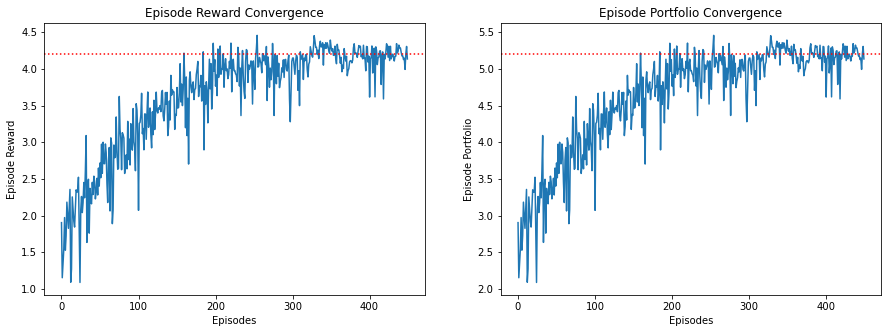

In [132]:
#Plotting test set reward and portfolio value to visualize convergence
plt.figure(0, figsize=(15,5))
plt.subplot(121)
plt.plot(all_episode_rewards)
plt.axhline(y=4.2, color='r', linestyle=':') #Drawing horizontal line at y=11
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.title('Episode Reward Convergence')
          
plt.subplot(122)
plt.plot(all_episode_portfolio)
plt.axhline(y=5.2, color='r', linestyle=':') #Drawing horizontal line at y=12
plt.xlabel('Episodes')
plt.ylabel('Episode Portfolio')
plt.title('Episode Portfolio Convergence')        
          
plt.show()

**RUNNING ON TEST SET**

In [18]:
#Loading the ms_dict
file3 = open("C:/Users/MSingh13/OneDrive - Schlumberger/IIIT/Dissertation/Hedging/Code/Heavy Runs/Static_Classification/market_state_scaled_dummy_dict.pickle", "rb")
ms_dict = pickle.load(file3)
file3.close()

In [19]:
#Getting initial state for Test set
test_start=[ms_dict.get(pd.to_datetime(datetime.date(2019,1,2))),1.0,{'sell_date':'cash'}]

In [16]:
#loading saved model for test data
loaded_model = tf.keras.models.load_model('Final_agent_model_dqn_nn_450')

In [17]:
def get_test_action(state, reshaped_encoded_state):
    valid_actions=env.get_valid_actions(state)
    valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
    q_value = loaded_model.predict(reshaped_encoded_state)
    valid_q_vals=[q_value[0][i] for i in valid_actions_idx]
    return valid_actions_idx[np.argmax(valid_q_vals)]

In [20]:
test_start[2]

{'sell_date': 'cash'}

In [21]:
#Running model on test data
test_trig2=[0,0,0,0,0,0,0]
episode_steps2=0
episode_reward2=0
episode_dividend2=0
test_rewards2=[]
test_portfolios2=[]
step_rewards2=[]
step_actions2=[]

#set to state corresponding to first trading day after 1/1/2019 at start of episode, state is [dataframe,array]
test_state = test_start.copy()
test_investment=test_state[1]
test_portfolio2=test_investment
step2=0

while (env.get_date(test_state)<=pd.to_datetime(datetime.date(2021,12,31))):#only or upto 31 Dec 2021
        
    # Reshaping in the form of (batch_size), state_size for input to neural network
    state_encod=env.state_encoder(test_state)
    #state = np.reshape(state, [1, state_size])
        
    # get action for the current state and go one step in environment
    action = get_test_action(test_state,state_encod.reshape(-1,329,57)) #agent.get_action(test_state,state_encod.reshape(-1,329,57)) 
    step_actions2.append(action)
    step2+=1
    
    next_state, reward, dividend, trig_count = env.action_success_fn(action,test_state)
    episode_reward2+=reward
    episode_steps2+=1
    episode_dividend2+=dividend
        
    test_trig2[0]+=trig_count[0]
    test_trig2[1]+=trig_count[1]
    test_trig2[2]+=trig_count[2]
    test_trig2[3]+=trig_count[3]
    test_trig2[4]+=trig_count[4]
    test_trig2[5]+=trig_count[5]
    test_trig2[6]+=trig_count[6]

    test_state = next_state  
    step_rewards2.append(reward)
    test_portfolio2+=reward
    test_rewards2.append(episode_reward2) #saving the reward at end of each episode
    test_portfolios2.append(test_portfolio2)

In [22]:
episode_steps2

757

In [23]:
test_portfolios2[-1]

2.2728787110474715

In [24]:
'ARR of model on Test Set with 450 episodes is {}%'.format(round(((((test_rewards2[-1]+1)/1)**(1/3)-1)*100),2))

'ARR of model on Test Set with 450 episodes is 31.48%'

In [34]:
#Sharpe Ratio
t=36/3
model_returns=[t*((test_portfolios2[i])**(21/i)-1) for i in range(21,757,21)]
len(model_returns)
((test_portfolios2[-1]**(1/3)-1)-0.0117)/np.std(model_returns)

2.527031956685298

In [35]:
print('There are {} trading days in test set. The agent chooses to trade on {} days only.'.format(episode_steps2,np.sum(test_trig2)))

There are 757 trading days in test set. The agent chooses to trade on 757 days only.


In [36]:
print('The total dividend captured by the agent is {} while the total profit in final portfolio at end of 3 years is {}.\nThis indicates that majority of the profits are captured from dividends while trading related losses bring it down. Despite this, the agent outperforms the S&P500 by more than 800 bps.'
      .format(round(episode_dividend2,2),round(test_rewards2[-1],2)))

The total dividend captured by the agent is 1.59 while the total profit in final portfolio at end of 3 years is 1.27.
This indicates that majority of the profits are captured from dividends while trading related losses bring it down. Despite this, the agent outperforms the S&P500 by more than 800 bps.


In [37]:
test_portfolios2.index(max(test_portfolios2[:350]))

281

In [38]:
min(test_portfolios2[280:400])

1.6409105152481198

In [39]:
#Max Drawdown
(test_portfolios2[281]-min(test_portfolios2[280:400]))/test_portfolios2[281]

0.08136910753342233

In [40]:
test_trig2

[377, 35, 141, 27, 99, 78, 0]

In [41]:
#Fraction of days traded
sum(test_trig2)/episode_steps2

1.0

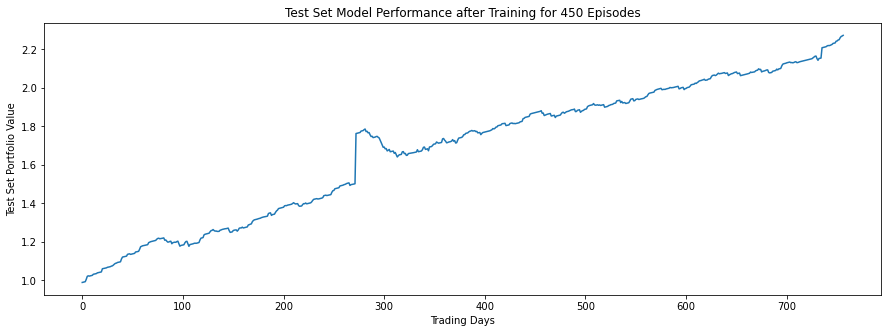

In [42]:
#Tracking inidividual episode total reward to check convergence
plt.figure(figsize=(15,5))
plt.plot(test_portfolios2)
#plt.axhline(y=1800, color='r', linestyle=':') #Drawing horizontal line at y=1800
plt.xlabel('Trading Days')
plt.ylabel('Test Set Portfolio Value')
plt.title('Test Set Model Performance after Training for 450 Episodes')
plt.show()

In [43]:
step_rewards2.index(max(step_rewards2))

272

In [44]:
step_rewards2[272]

0.2609663034605274

In [45]:
'ARR of model without the outlier dividend payment in test set is {}% which also beats the S&P500 ARR for same time period'.format(round(((((test_portfolio2-step_rewards2[272])/1)**(1/3)-1)*100),2))

'ARR of model without the outlier dividend payment in test set is 26.24% which also beats the S&P500 ARR for same time period'

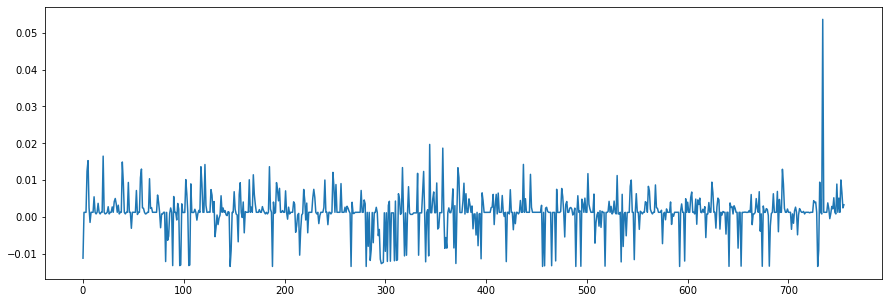

In [46]:
plot_rew=[i for i in step_rewards2]
plot_rew.remove(plot_rew[272])
#Ensuring performance is consistent and not one-off big reward
plt.figure(figsize=(15,5))
plt.plot(plot_rew)
plt.show()

In [318]:
#saving portfolio values on test set as excel file
pd.DataFrame(test_portfolios2).to_excel("dqn_test.xlsx") 